<a href="https://colab.research.google.com/github/norgaston/laboratorio2-mlbd/blob/main/Laboratorio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Laboratorio 2 - Clasificador de canciones de Spotify**

ELEMENTOS DE APRENDIZAJE DE MÁQUINA Y BIG DATA

Carrera: T.U. TECNOLOGÍAS DE PROGRAMACIÓN SEDE PUNTA ALTA
Facultad: Facultad de la Micro, Pequeña y Mediana Empresa (UPSO)
Docente: Valentín Barco
Cuatrimestre/Año: 2° Cuatrimestre 2023

En este laboratorio, nos enfocaremos en un conjunto de datos repleto de atributos clave de
distintas canciones. La meta es establecer a través de herramientas de aprendizaje
automático, un clasificador que pueda predecir las inclinaciones musicales de un individuo y
predecir si disfrutará o no de una determinada canción.

**Integrantes del Grupo 12: Dolores Ponce y Gaston Ponce**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Bibliotecas necesarias**

In [ ]:
# Importa las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

### **Carga y preprocesado de los datos**

In [ ]:
# Carga los datos en un DataFrame de Pandas
ruta = '/content/Canciones_Spotify.csv' # ruta desde donde voy a cargar el dataset
data = pd.read_csv(ruta, encoding='latin-1')
data = data.dropna()
# Elimino la primera columna (columna 0) utilizando el método drop
data.drop('Unnamed: 0', axis=1, inplace=True)

### **Análisis exploratorio de los datos**

In [ ]:
print("\nInformación del dataframe:\n")
print(data.info())


Información del dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2017 non-null   float64
 1   danceability      2017 non-null   float64
 2   duration_ms       2017 non-null   int64  
 3   energy            2017 non-null   float64
 4   instrumentalness  2017 non-null   float64
 5   key               2017 non-null   int64  
 6   liveness          2017 non-null   float64
 7   loudness          2017 non-null   float64
 8   mode              2017 non-null   int64  
 9   speechiness       2017 non-null   float64
 10  tempo             2017 non-null   float64
 11  time_signature    2017 non-null   float64
 12  valence           2017 non-null   float64
 13  target            2017 non-null   int64  
 14  song_title        2017 non-null   object 
 15  artist            2017 non-null   object 
dtypes: float64(10

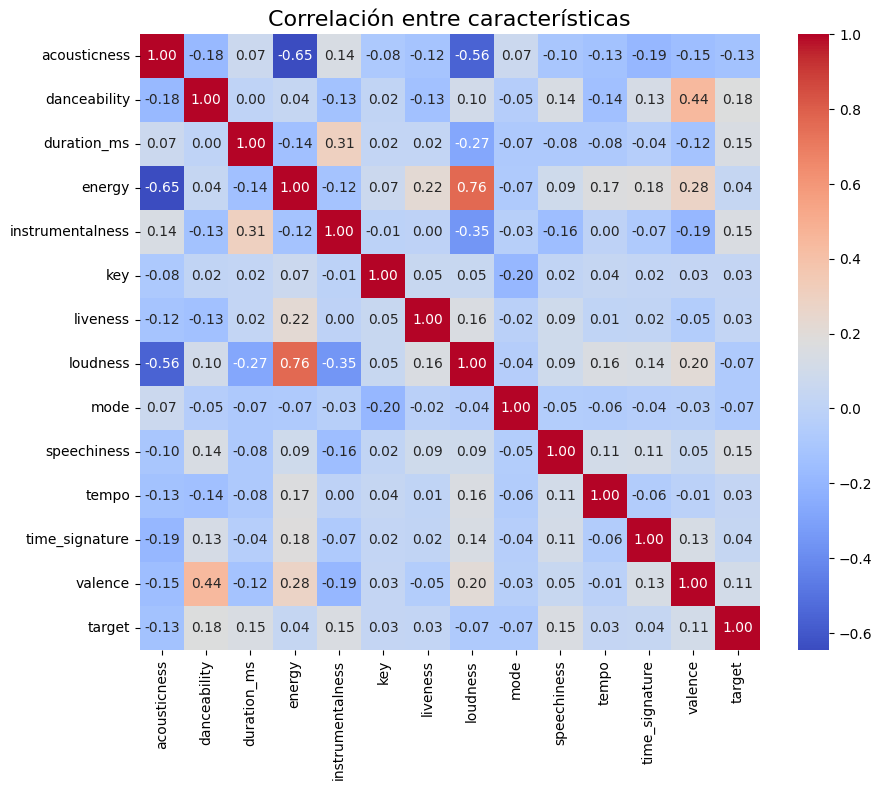

In [ ]:
# Correlación entre las características
correlation_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación entre características', fontsize=16)
plt.show()

### **Preparación de Datos y Entrenamiento de los Modelos de Clasificación**

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = data.drop(['target', 'song_title', 'artist'], axis=1)
y = data['target']

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Realizar selección de características utilizando PCA
num_components = 13  # Elige el número de componentes principales a retener
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_scaled)

# Crear DataFrames para las características seleccionadas después de PCA
X_selected = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, num_components + 1)])

# Dividir los datos seleccionados en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.10, random_state=42)

# Configurar hiperparámetros
knn_model = KNeighborsClassifier(algorithm='ball_tree',n_neighbors=19,p=1,weights='distance')
svm_model = SVC(C=1.5, class_weight='balanced', gamma='scale', kernel='rbf',probability=True)
decision_tree_model = DecisionTreeClassifier(random_state=42,ccp_alpha=0.001)
naive_bayes_model = GaussianNB()
rf_model = RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300, oob_score=True, ccp_alpha=0.0004)

# Entrenar modelos
knn_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
naive_bayes_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Realizar predicciones
knn_predictions = knn_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)
decision_tree_predictions = decision_tree_model.predict(X_test)
naive_bayes_predictions = naive_bayes_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)

### **Funciones para graficar la matriz de confusión y la curva ROC para cada modelo**

In [ ]:
# Función para graficar la matriz de confusión con valores
def plot_confusion_matrix_with_values(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    classes = ['No Gusta', 'Gusta']
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), horizontalalignment='center', verticalalignment='center', color='black', fontsize=15)
    plt.xticks([0, 1], classes, rotation=45)
    plt.yticks([0, 1], classes)
    plt.tight_layout()
    plt.ylabel('Canciones Verdaderas')
    plt.xlabel('Canciones Predichas')

# Función para graficar la curva ROC y calcular el AUC
def plot_roc_curve(y_true, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')

### **Evaluación de los modelos**

**K-Nearest Neighbors**

K-Nearest Neighbors:
[[94 15]
 [34 59]]
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       109
           1       0.80      0.63      0.71        93

    accuracy                           0.76       202
   macro avg       0.77      0.75      0.75       202
weighted avg       0.76      0.76      0.75       202



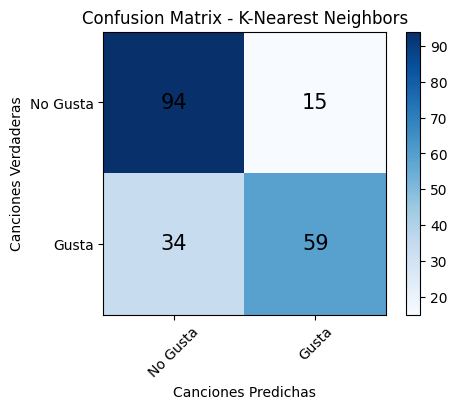

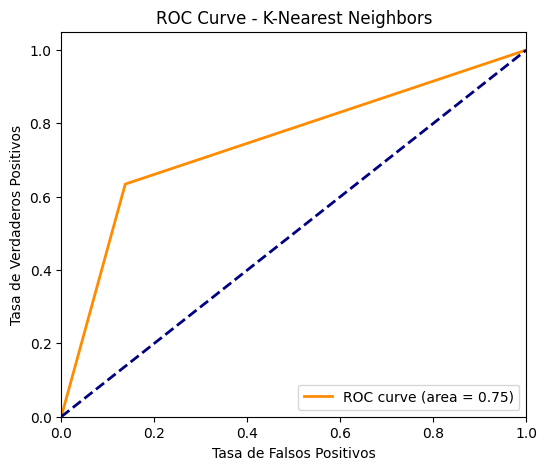

In [ ]:
print("K-Nearest Neighbors:")
print(confusion_matrix(y_test, knn_predictions))
print(classification_report(y_test, knn_predictions))

plot_confusion_matrix_with_values(y_test, knn_predictions, 'K-Nearest Neighbors')
plt.show()
plot_roc_curve(y_test, knn_predictions, 'K-Nearest Neighbors')
plt.show()

**Support Vector Machine**

Support Vector Machine:
[[92 17]
 [22 71]]
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       109
           1       0.81      0.76      0.78        93

    accuracy                           0.81       202
   macro avg       0.81      0.80      0.80       202
weighted avg       0.81      0.81      0.81       202



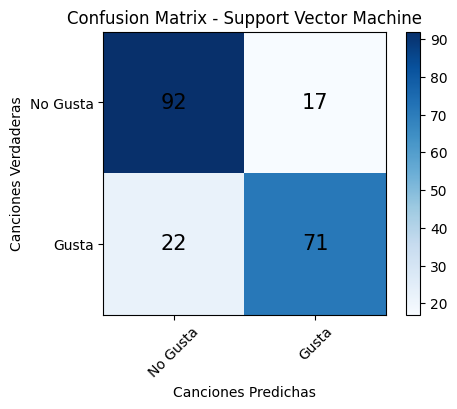

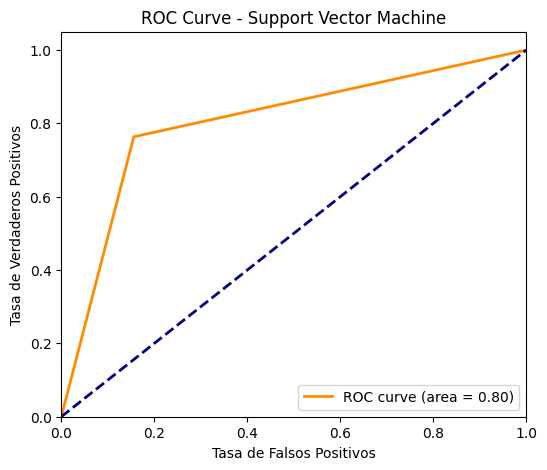

In [ ]:
print("Support Vector Machine:")
print(confusion_matrix(y_test, svm_predictions))
print(classification_report(y_test, svm_predictions))

plot_confusion_matrix_with_values(y_test, svm_predictions, 'Support Vector Machine')
plt.show()
plot_roc_curve(y_test, svm_predictions, 'Support Vector Machine')
plt.show()

**Decision Tree**

Decision Tree:
[[69 40]
 [28 65]]
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       109
           1       0.62      0.70      0.66        93

    accuracy                           0.66       202
   macro avg       0.67      0.67      0.66       202
weighted avg       0.67      0.66      0.66       202



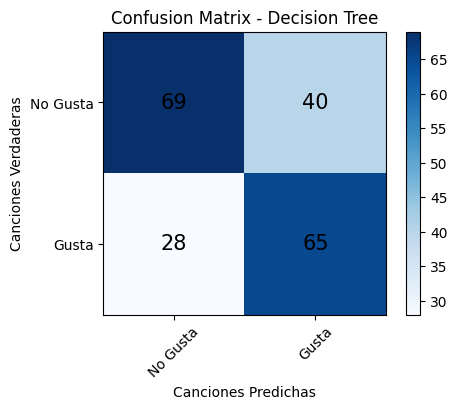

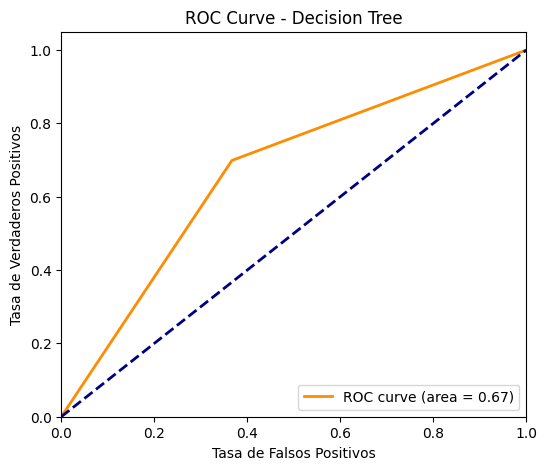

In [ ]:
print("Decision Tree:")
print(confusion_matrix(y_test, decision_tree_predictions))
print(classification_report(y_test, decision_tree_predictions))

plot_confusion_matrix_with_values(y_test, decision_tree_predictions, 'Decision Tree')
plt.show()
plot_roc_curve(y_test, decision_tree_predictions, 'Decision Tree')
plt.show()

**Naive Bayes**

Naive Bayes:
[[84 25]
 [30 63]]
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       109
           1       0.72      0.68      0.70        93

    accuracy                           0.73       202
   macro avg       0.73      0.72      0.72       202
weighted avg       0.73      0.73      0.73       202



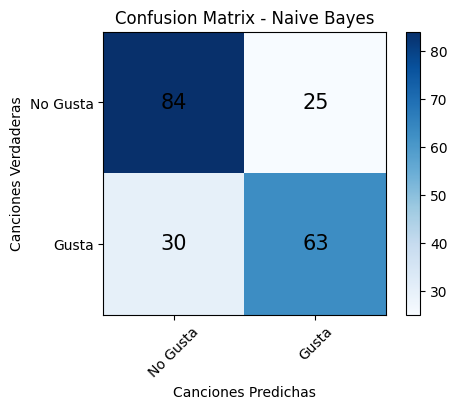

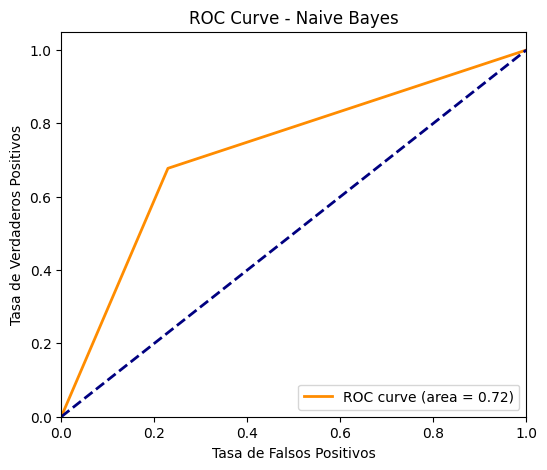

In [ ]:
print("Naive Bayes:")
print(confusion_matrix(y_test, naive_bayes_predictions))
print(classification_report(y_test, naive_bayes_predictions))

plot_confusion_matrix_with_values(y_test, naive_bayes_predictions, 'Naive Bayes')
plt.show()
plot_roc_curve(y_test, naive_bayes_predictions, 'Naive Bayes')
plt.show()

**Random Forest**

Random Forest:
[[83 26]
 [21 72]]
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       109
           1       0.73      0.77      0.75        93

    accuracy                           0.77       202
   macro avg       0.77      0.77      0.77       202
weighted avg       0.77      0.77      0.77       202



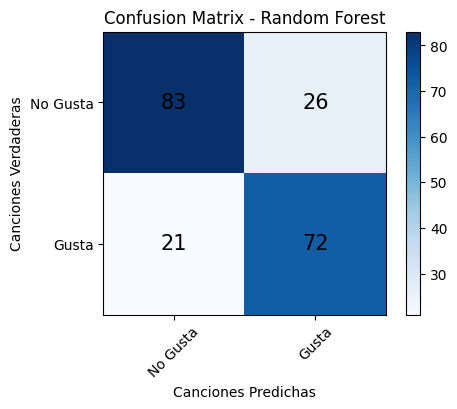

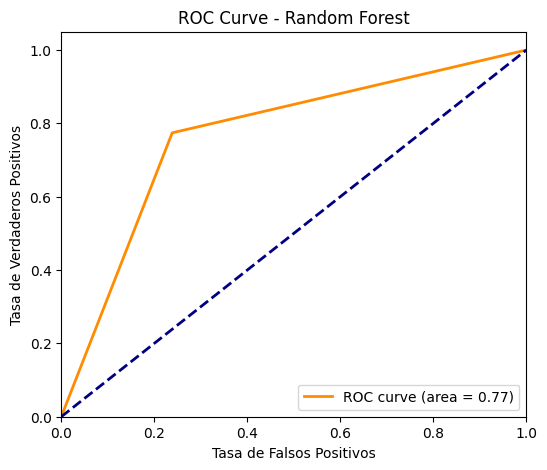

In [ ]:
print("Random Forest:")
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

plot_confusion_matrix_with_values(y_test, rf_predictions, 'Random Forest')
plt.show()
plot_roc_curve(y_test, rf_predictions, 'Random Forest')
plt.show()

**Votación Mayoritaria**

Ensamble (Votación Mayoritaria):
[[92 17]
 [23 70]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       109
           1       0.80      0.75      0.78        93

    accuracy                           0.80       202
   macro avg       0.80      0.80      0.80       202
weighted avg       0.80      0.80      0.80       202



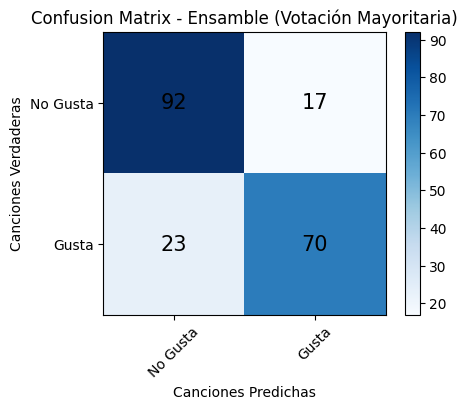

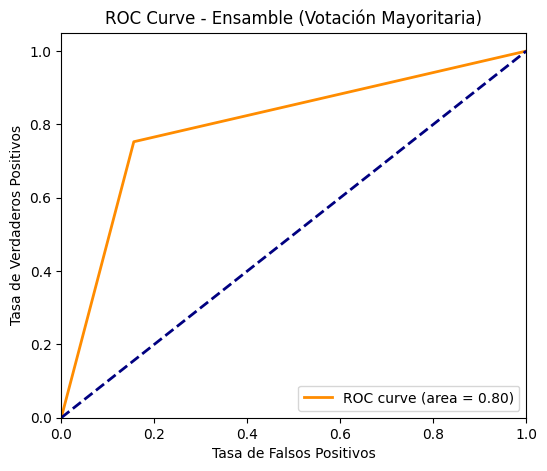

In [ ]:
# Ensamble de modelos (Votación mayoritaria)
ensemble_model = VotingClassifier(estimators=[('KNN', knn_model), ('SVM', svm_model), ('DecisionTree', decision_tree_model), ('NaiveBayes', naive_bayes_model), ('RandomForest', rf_model)], voting='hard')
ensemble_model.fit(X_train, y_train)
ensemble_predictions = ensemble_model.predict(X_test)

# Evaluar el ensamble
print("Ensamble (Votación Mayoritaria):")
print(confusion_matrix(y_test, ensemble_predictions))
print(classification_report(y_test, ensemble_predictions))

plot_confusion_matrix_with_values(y_test, ensemble_predictions, 'Ensamble (Votación Mayoritaria)')
plt.show()
plot_roc_curve(y_test, ensemble_predictions, 'Ensamble (Votación Mayoritaria)')
plt.show()

### **Comparación de las métricas resultantes de cada uno de los modelos** ###

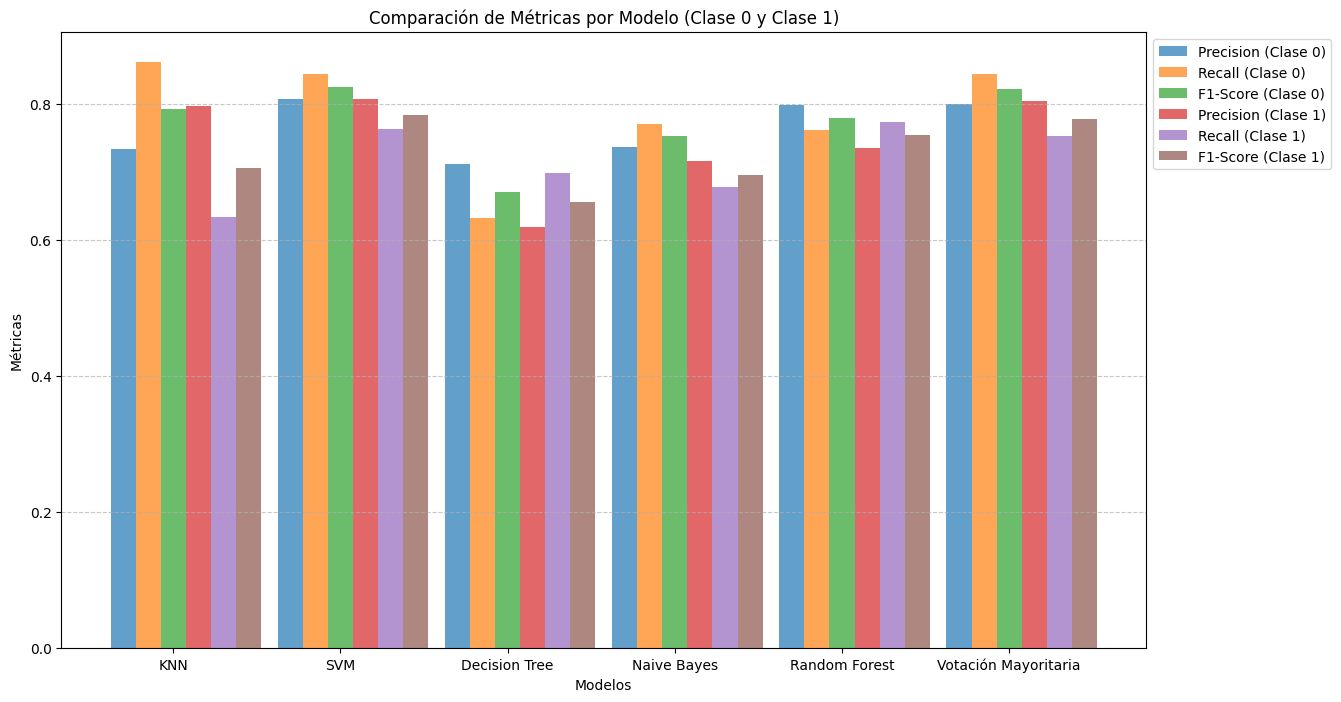

In [ ]:
# Resultados de classification_report para cada modelo
report_knn = classification_report(y_test, knn_predictions, output_dict=True)
report_svm = classification_report(y_test, svm_predictions, output_dict=True)
report_decision_tree = classification_report(y_test, decision_tree_predictions, output_dict=True)
report_naive_bayes = classification_report(y_test, naive_bayes_predictions, output_dict=True)
report_rf = classification_report(y_test, rf_predictions, output_dict=True)
report_ensemble = classification_report(y_test, ensemble_predictions, output_dict=True)

# Métricas y modelos
metrics = ['precision', 'recall', 'f1-score']
models = ['KNN', 'SVM', 'Decision Tree', 'Naive Bayes', 'Random Forest', 'Votación Mayoritaria']

# Valores de métricas para ambas clases y modelos
precision_values_class_0 = [report_knn['0']['precision'], report_svm['0']['precision'], report_decision_tree['0']['precision'], report_naive_bayes['0']['precision'], report_rf['0']['precision'], report_ensemble['0']['precision']]
recall_values_class_0 = [report_knn['0']['recall'], report_svm['0']['recall'], report_decision_tree['0']['recall'], report_naive_bayes['0']['recall'], report_rf['0']['recall'], report_ensemble['0']['recall']]
f1_score_values_class_0 = [report_knn['0']['f1-score'], report_svm['0']['f1-score'], report_decision_tree['0']['f1-score'], report_naive_bayes['0']['f1-score'], report_rf['0']['f1-score'], report_ensemble['0']['f1-score']]

precision_values_class_1 = [report_knn['1']['precision'], report_svm['1']['precision'], report_decision_tree['1']['precision'], report_naive_bayes['1']['precision'], report_rf['1']['precision'], report_ensemble['1']['precision']]
recall_values_class_1 = [report_knn['1']['recall'], report_svm['1']['recall'], report_decision_tree['1']['recall'], report_naive_bayes['1']['recall'], report_rf['1']['recall'], report_ensemble['1']['recall']]
f1_score_values_class_1 = [report_knn['1']['f1-score'], report_svm['1']['f1-score'], report_decision_tree['1']['f1-score'], report_naive_bayes['1']['f1-score'], report_rf['1']['f1-score'], report_ensemble['1']['f1-score']]

# Configuración del gráfico
plt.figure(figsize=(14, 8))
bar_width = 0.15
index = range(len(models))

# Crear gráfico de barras para precisión (Clase 0)
plt.bar(index, precision_values_class_0, bar_width, label='Precision (Clase 0)', alpha=0.7)
# Crear gráfico de barras para recall (Clase 0)
plt.bar([i + bar_width for i in index], recall_values_class_0, bar_width, label='Recall (Clase 0)', alpha=0.7)
# Crear gráfico de barras para f1-score (Clase 0)
plt.bar([i + 2 * bar_width for i in index], f1_score_values_class_0, bar_width, label='F1-Score (Clase 0)', alpha=0.7)

# Crear gráfico de barras para precisión (Clase 1)
plt.bar([i + 3 * bar_width for i in index], precision_values_class_1, bar_width, label='Precision (Clase 1)', alpha=0.7)
# Crear gráfico de barras para recall (Clase 1)
plt.bar([i + 4 * bar_width for i in index], recall_values_class_1, bar_width, label='Recall (Clase 1)', alpha=0.7)
# Crear gráfico de barras para f1-score (Clase 1)
plt.bar([i + 5 * bar_width for i in index], f1_score_values_class_1, bar_width, label='F1-Score (Clase 1)', alpha=0.7)

plt.xlabel('Modelos')
plt.ylabel('Métricas')
plt.title('Comparación de Métricas por Modelo (Clase 0 y Clase 1)')

# Ajustar la posición de la leyenda fuera del gráfico
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xticks([i + 2 * bar_width for i in index], models)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [ ]:
# Crear un DataFrame de pandas con los resultados
data = {
    "Modelo": ["KNN", "SVM", "Decision Tree", "Naive Bayes", "Random Forest", "Votación Mayoritaria"],
    "Precisión (Clase 0)": [report_knn['0']['precision'], report_svm['0']['precision'], report_decision_tree['0']['precision'], report_naive_bayes['0']['precision'], report_rf['0']['precision'], report_ensemble['0']['precision']],
    "Recall (Clase 0)": [report_knn['0']['recall'], report_svm['0']['recall'], report_decision_tree['0']['recall'], report_naive_bayes['0']['recall'], report_rf['0']['recall'], report_ensemble['0']['recall']],
    "F1-Score (Clase 0)": [report_knn['0']['f1-score'], report_svm['0']['f1-score'], report_decision_tree['0']['f1-score'], report_naive_bayes['0']['f1-score'], report_rf['0']['f1-score'], report_ensemble['0']['f1-score']],
    "Precisión (Clase 1)": [report_knn['1']['precision'], report_svm['1']['precision'], report_decision_tree['1']['precision'], report_naive_bayes['1']['precision'], report_rf['1']['precision'], report_ensemble['1']['precision']],
    "Recall (Clase 1)": [report_knn['1']['recall'], report_svm['1']['recall'], report_decision_tree['1']['recall'], report_naive_bayes['1']['recall'], report_rf['1']['recall'], report_ensemble['1']['recall']],
    "F1-Score (Clase 1)": [report_knn['1']['f1-score'], report_svm['1']['f1-score'], report_decision_tree['1']['f1-score'], report_naive_bayes['1']['f1-score'], report_rf['1']['f1-score'], report_ensemble['1']['f1-score']],
    "Exactitud": [report_knn['accuracy'], report_svm['accuracy'], report_decision_tree['accuracy'], report_naive_bayes['accuracy'], report_rf['accuracy'], report_ensemble['accuracy']]
}
resultados = pd.DataFrame(data)

### **Conclusiones:**

En esta tabla, se puede ver claramente cómo cada modelo se desempeña en términos de precisión, recall, f1-score y exactitud para ambas clases.

---



In [ ]:
resultados

,Modelo,Precisión (Clase 0),Recall (Clase 0),F1-Score (Clase 0),Precisión (Clase 1),Recall (Clase 1),F1-Score (Clase 1),Exactitud
0,KNN,0.734375,0.862385,0.793249,0.797297,0.634409,0.706587,0.757426
1,SVM,0.807018,0.844037,0.825112,0.806818,0.763441,0.784530,0.806931
2,Decision Tree,0.711340,0.633028,0.669903,0.619048,0.698925,0.656566,0.663366
3,Naive Bayes,0.736842,0.770642,0.753363,0.715909,0.677419,0.696133,0.727723
4,Random Forest,0.798077,0.761468,0.779343,0.734694,0.774194,0.753927,0.767327
5,Votación Mayoritaria,0.800000,0.844037,0.821429,0.804598,0.752688,0.777778,0.801980


Basándonos en los resultados de los modelos de clasificación en este estudio, podemos hacer las siguientes conclusiones:

**Random Forest** y **SVM** son los dos modelos que destacan en términos de precisión, recall y F1-Score en ambas clases (Clase 0 y Clase 1). Ambos modelos logran una alta precisión y un equilibrio entre recall y F1-Score, lo que sugiere que son buenas opciones para este problema de clasificación. La exactitud general también es alta en ambos casos.

**Votación Mayoritaria** combina las fortalezas de varios modelos, lo que resulta en resultados sólidos en términos de precisión y recall en ambas clases. La exactitud general es bastante alta, lo que indica que el enfoque de ensamblaje puede ser una estrategia efectiva.

**KNN** y **Naive Bayes** también muestran un rendimiento razonable, con F1-Scores competitivos. Sin embargo, su precisión y recall en la Clase 1 son ligeramente más bajos en comparación con Random Forest y SVM.

**Decision Tree**, aunque es una opción válida, tiene un rendimiento general más bajo en términos de precisión y F1-Score en ambas clases.

En general, tanto Random Forest como SVM son las opciones más prometedoras para predecir las preferencias en este conjunto de datos, mientras que la votación mayoritaria demuestra ser una estrategia efectiva. La elección del modelo final dependerá de otros factores, como la escalabilidad y la interpretación de los resultados.





